In [7]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os, shutil

from scipy.ndimage import gaussian_filter, uniform_filter

In [8]:
dir_low = 'data/CFRP_60_low/'
dir_high = 'data/CFRP_60_high/'
dir_result = 'data/enhanced/'
in_size = (40, 120)
out_size = (80, 240)

Original image size (WxH): (382, 288)
Brightest point found at (x, y): (195, 153)
Calculated crop box (left, upper, right, lower): (np.int64(175), np.int64(93), np.int64(215), np.int64(213))


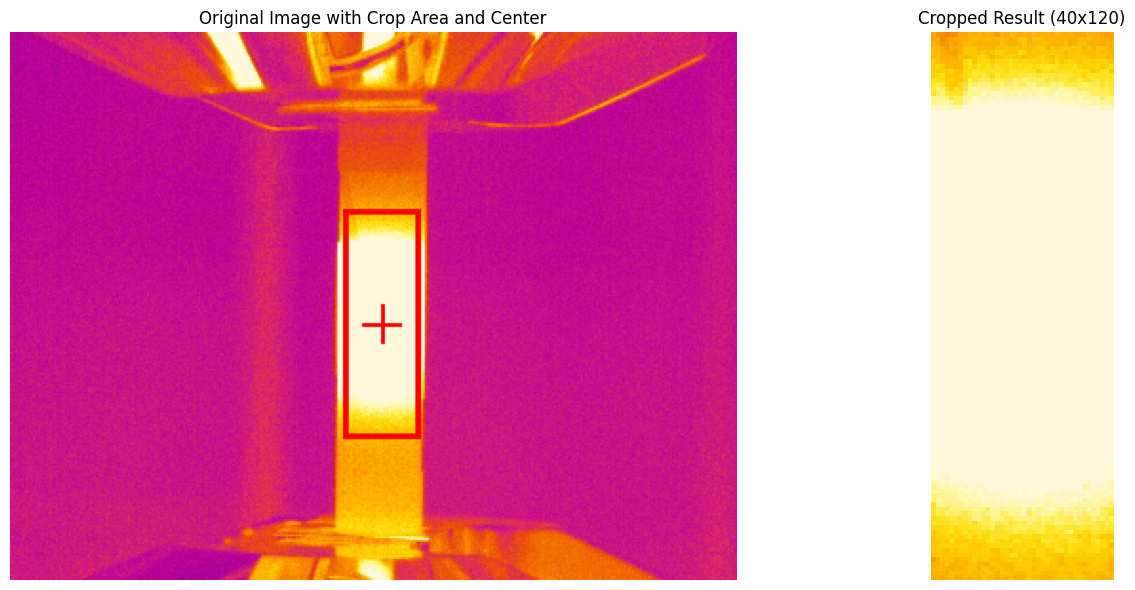

Original image size (WxH): (174, 512)
Brightest point found at (x, y): (67, 278)
Calculated crop box (left, upper, right, lower): (np.int64(27), np.int64(158), np.int64(107), np.int64(398))


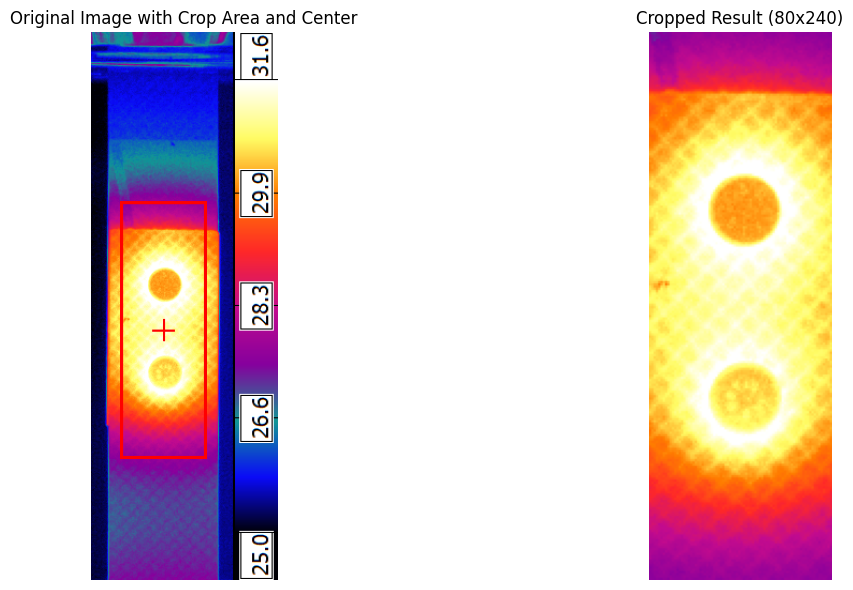

In [9]:
def crop_to_brightest_plot(image_path: str, crop_size: tuple[int, int]):
    try:
        original_image = Image.open(image_path)
    except FileNotFoundError:
        print(f"Error: The file '{image_path}' was not found.")
        return
    except Exception as e:
        print(f"Error opening or reading the image: {e}")
        return


    if original_image.mode not in ['I', 'F', 'L']:
        grayscale_image = original_image.convert('L') # 'L' converts to 8-bit grayscale, which is fine for finding the location of max brightness
    else:
        grayscale_image = original_image

    image_array = np.array(grayscale_image)
    window_size = 150
    filtered_image = gaussian_filter(image_array.astype(np.float32), sigma= window_size/6)

    # Find the coordinates of the maximum value in the filtered image.
    # This corresponds to the center of the brightest 100x100 block.
    max_loc = np.unravel_index(np.argmax(filtered_image), filtered_image.shape)
    # In image coordinates, this is (y, x)
    center_y, center_x = max_loc

    print(f"Original image size (WxH): {original_image.size}")
    print(f"Brightest point found at (x, y): ({center_x}, {center_y})")
    crop_width, crop_height = crop_size

    left = center_x - crop_width // 2
    upper = center_y - crop_height // 2
    right = left + crop_width
    lower = upper + crop_height

    left = max(0, left)
    upper = max(0, upper)
    right = min(original_image.width, right)
    lower = min(original_image.height, lower)

    crop_box = (left, upper, right, lower)
    print(f"Calculated crop box (left, upper, right, lower): {crop_box}")

    cropped_image = original_image.crop(crop_box)
    viz_image = original_image.convert("RGB")
    draw = ImageDraw.Draw(viz_image)
    draw.rectangle(crop_box, outline="red", width=3)


    cross_size = 10
    draw.line((center_x - cross_size, center_y, center_x + cross_size, center_y), fill="red", width=2)
    draw.line((center_x, center_y - cross_size, center_x, center_y + cross_size), fill="red", width=2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].imshow(viz_image)
    axes[0].set_title("Original Image with Crop Area and Center")
    axes[0].axis('off')
    cmap = 'gray' if cropped_image.mode != 'RGB' else None
    axes[1].imshow(cropped_image, cmap=cmap)
    axes[1].set_title(f"Cropped Result ({cropped_image.width}x{cropped_image.height})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


crop_to_brightest_plot(os.path.join(dir_low,"Record_2025-11-11_10-42-17.tiff"), in_size)
crop_to_brightest_plot(os.path.join(dir_high,"prst_A_stat_03_5_230149.png"), out_size)



In [10]:
def crop_relevant_zone(image_path: str, crop_size: tuple[int, int]):
    try:
        original_image = Image.open(image_path)
    except FileNotFoundError:
        print(f"Error: The file '{image_path}' was not found.")
        return
    except Exception as e:
        print(f"Error opening or reading the image: {e}")
        return

    if original_image.mode not in ['I', 'F', 'L']:
        grayscale_image = original_image.convert('L') # 'L' converts to 8-bit grayscale, which is fine for finding the location of max brightness
    else:
        grayscale_image = original_image

    image_array = np.array(grayscale_image)
    window_size = 150
    filtered_image = gaussian_filter(image_array.astype(np.float32), sigma= window_size/6)

    max_loc = np.unravel_index(np.argmax(filtered_image), filtered_image.shape)
    center_y, center_x = max_loc

    crop_width, crop_height = crop_size

    left = center_x - crop_width // 2
    upper = center_y - crop_height // 2
    right = left + crop_width
    lower = upper + crop_height

    left = max(0, left)
    upper = max(0, upper)
    right = min(original_image.width, right)
    lower = min(original_image.height, lower)

    crop_box = (left, upper, right, lower)
    cropped_image = original_image.crop(crop_box)
    return cropped_image


in_size = (40, 120)
out_size = (80, 240)
crop_relevant_zone(os.path.join(dir_low,"Record_2025-11-11_10-42-17.tiff"), in_size)
crop_relevant_zone(os.path.join(dir_high,"prst_A_stat_03_5_230149.png"), out_size)

def flip(image: Image.Image, horizontal: bool = False, vertical: bool = False) -> Image.Image:
    if horizontal:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if vertical:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    return image



In [18]:
def main(average=False):
    flip_possible = [(False, False), (True, False), (False, True), (True, True)]

    # Create output directory / reset it 
    if not os.path.exists(dir_result):
        os.makedirs(dir_result)
    else : 
        shutil.rmtree(dir_result)
        os.makedirs(dir_result)
    os.makedirs(os.path.join(dir_result,'low'))
    os.makedirs(os.path.join(dir_result,'high'))

    if not average :
        print('Processing without averaging...')

        # Process low-resolution images
        print("--- Processing low-resolution images ---")
        image_count = 0
        number_of_images = len([name for name in os.listdir(dir_low) if name.endswith('.tiff')])*4
        for filename in os.listdir(dir_low):
            if filename.endswith('.tiff'):
                inputh_path = os.path.join(dir_low, filename)
                cropped_image = crop_relevant_zone(inputh_path, in_size)
                for h_flip, v_flip in flip_possible:
                    augmented_image = flip(cropped_image, horizontal=h_flip, vertical=v_flip)
                    output_path = os.path.join(dir_result,'low', f"{image_count}.tiff")
                    augmented_image.save(output_path)
                    image_count += 1
                    print(f"Processed and saved image: {image_count}/{number_of_images}", end='\r')
        
        # Process high-resolution images
        print("--- Processing high-resolution images ---")
        image_count = 0
        for filename in os.listdir(dir_high):
            if filename.endswith('.png'):
                inputh_path = os.path.join(dir_high, filename)
                cropped_image = crop_relevant_zone(inputh_path, out_size)
                for h_flip, v_flip in flip_possible:
                    augmented_image = flip(cropped_image, horizontal=h_flip, vertical=v_flip)
                    output_path = os.path.join(dir_result,'high', f"{image_count}.png")
                    augmented_image.save(output_path)
                    image_count += 1
                    print(f"Processed and saved image: {image_count}/{number_of_images}", end='\r')

    else :
        print('Processing with averaging...')

        # Process low-resolution images
        print("--- Processing low-resolution images ---")
        image_count = 0
        number_of_images = len([name for name in os.listdir(dir_low) if name.endswith('.tiff')])*4*(len([name for name in os.listdir(dir_low) if name.endswith('.tiff')])-1)
        for filename1 in os.listdir(dir_low):
            for filename2 in os.listdir(dir_low):
                if filename1.endswith('.tiff') and filename2.endswith('.tiff') and filename1 != filename2:
                    inputh_path = os.path.join(dir_low, filename1)
                    cropped_image1 = crop_relevant_zone(inputh_path, in_size)
                    inputh_path = os.path.join(dir_low, filename2)
                    cropped_image2 = crop_relevant_zone(inputh_path, in_size)
                    average_image = Image.blend(cropped_image1, cropped_image2, alpha=0.5)

                    for h_flip, v_flip in flip_possible:
                        augmented_image = flip(average_image, horizontal=h_flip, vertical=v_flip)
                        output_path = os.path.join(dir_result,'low', f"{image_count}.tiff")
                        augmented_image.save(output_path)
                        image_count += 1
                        print(f"Processed and saved image: {image_count}/{number_of_images}", end='\r')
        
        # Process high-resolution images
        print("--- Processing high-resolution images ---")
        image_count = 0
        for filename1 in os.listdir(dir_high):
            for filename2 in os.listdir(dir_high):
                if filename1.endswith('.png') and filename2.endswith('.png') and filename1 != filename2:
                    inputh_path = os.path.join(dir_high, filename1)
                    cropped_image1 = crop_relevant_zone(inputh_path, in_size)
                    inputh_path = os.path.join(dir_high, filename2)
                    cropped_image2 = crop_relevant_zone(inputh_path, in_size)
                    average_image = Image.blend(cropped_image1, cropped_image2, alpha=0.5)

                    for h_flip, v_flip in flip_possible:
                        augmented_image = flip(average_image, horizontal=h_flip, vertical=v_flip)
                        output_path = os.path.join(dir_result,'high', f"{image_count}.png")
                        augmented_image.save(output_path)
                        image_count += 1
                        print(f"Processed and saved image: {image_count}/{number_of_images}", end='\r')



if __name__ == "__main__" : 
    main(average=False)  


    

Processing without averaging...
--- Processing low-resolution images ---
--- Processing high-resolution images ---
